In [ ]:
WORKDIR = "/mnt/scratch/daniel/Data/AnaContML"
import h5py
import matplotlib.pyplot as plt
import numpy as np 

with h5py.File(WORKDIR+"/valid_scripts/maxent_skew_data_100_b20.h5", "r") as f:
    gtau = f["gtau"][:]
    A = f["A"][:]
    w = f["w"][:]
    A_maxent = f["A_maxent"][:]
    w_maxent = f["w_maxent"][:]
    maxent_beta = np.array(f["beta"])

with h5py.File(WORKDIR+"/valid_scripts/GNN_1_base_MIT_skew_2025-11-21_100_bs10_v2.h5", "r") as f:
    print(f.keys())
    print(f["ctqmc"].keys())
    Green_train = np.array(f["train"]["green"])
    A_train_GNN = np.array(f["train"]["prediction"])
    A_train_GNN_target = np.array(f["train"]["target"])

    Green_valid = np.array(f["valid"]["green"])
    A_valid_GNN = np.array(f["valid"]["prediction"])
    A_valid_GNN_target = np.array(f["valid"]["target"])

    beta =[20,30,40]
    GNN_ctqmc = {}
    for b in beta:
        b = str(b)
        GNN_ctqmc[b] = {}
        GNN_ctqmc[b]["Green_ctqmc"] = np.array(f["ctqmc"][b]["green"])
        GNN_ctqmc[b]["A_ctqmc_GNN"] = np.array(f["ctqmc"][b]["prediction"])
        GNN_ctqmc[b]["U_ctqmc_GNN"] = np.array(f["ctqmc"][b]["U"])/10

v = np.load(WORKDIR+"/data_2025_new/ctqmc_kernels_100/lambda_200/v.npy")
u = np.load(WORKDIR+"/data_2025_new/ctqmc_kernels_100/lambda_200/u.npy")
s = np.load(WORKDIR+"/data_2025_new/ctqmc_kernels_100/lambda_200/s.npy")
k = np.load(WORKDIR+"/data_2025_new/ctqmc_kernels_100/lambda_200/kernel.npy")

<KeysViewHDF5 ['ctqmc', 'train', 'valid']>
<KeysViewHDF5 ['20', '30', '40']>


In [ ]:
import json
import torch 

MODEL_NAME = "GNN_1_base"
config = json.load(open(WORKDIR+'/_runs/confmod_graph_neural_network_MIT_w100_n100_skew1.json'))[MODEL_NAME]

def create_datasets(config):
    data = np.load(config["PATH_TRAIN"])
    train, validation = torch.utils.data.random_split(
        data,
        [int(len(data) * config["SPLIT"]),
         len(data) - int(len(data) * config["SPLIT"])],
        generator=torch.Generator().manual_seed(42),
    )
    return train.indices, validation.indices

train_idx, validation_idx = create_datasets(config)

A_GNN_ordered = np.zeros(A.shape)
A_GNN_target_ordered = np.zeros(A.shape)

for n in range(len(train_idx)):
    A_GNN_ordered[train_idx[n]] = A_train_GNN[n]
    A_GNN_target_ordered[train_idx[n]] = A_train_GNN_target[n]

for n in range(len(validation_idx)):
    A_GNN_ordered[validation_idx[n]] = A_valid_GNN[n]
    A_GNN_target_ordered[validation_idx[n]] = A_valid_GNN_target[n]


In [3]:
n_samples = A_maxent.shape[0]
n_omega = A_maxent.shape[1]
A_maxent_int = np.zeros((n_samples, w.shape[0]))
for n in range(n_samples):
    A_maxent_int[n] = np.interp(w, w_maxent, A_maxent[n,:])

n_samples_GNN = A_GNN_ordered.shape[0]

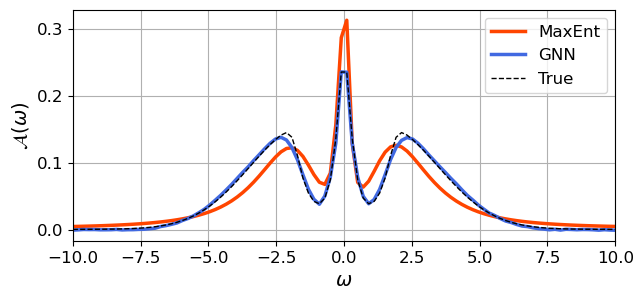

In [4]:
N = int(np.random.rand() * 1e4)
N = 7145

fig,ax = plt.subplots(ncols=1, figsize=(7,3))
ax.plot(w_maxent,A_maxent[N]/np.trapz(x=w_maxent, y=A_maxent[N]), linewidth=2.5, color='orangered', label=r'MaxEnt')
ax.plot(w,A_GNN_ordered[N], "-", linewidth=2.5,color='royalblue', label="GNN")
ax.plot(w,A[N], "--", linewidth=1, color='black', label="True")
# ax.set_ylim([0,max(A[N])*1.1])
ax.legend(fontsize=12)
ax.set_xlabel(r"$\omega$", fontsize=14)
ax.set_ylabel(r'$\mathcal{A}(\omega)$', fontsize=14)
ax.tick_params(axis='both', labelsize=12)  # Adjust 14 to your desired font size
ax.set_xlim([min(w),max(w)])
ax.grid()
plt.savefig(f"examples/Aw_avnoise_ex{N}.pdf", format="pdf", bbox_inches="tight")


In [5]:
print(N)

# 4055 6801 7145 3440 1554 3052

7145


In [6]:
coeffs = np.zeros((n_samples, n_omega))
coeffs_all = np.zeros((n_samples_GNN, n_omega))
coeffs_maxent = np.zeros((n_samples, n_omega))
coeffs_GNN = np.zeros((n_samples_GNN, n_omega))
print(n_samples)

for n in range(n_samples):
    coeffs[n,:] = A[n] @ v.transpose()
    coeffs_maxent[n,:] = A_maxent_int[n] @ v.transpose()
for n in range(n_samples_GNN):
    coeffs_GNN[n,:] = A_GNN_ordered[n] @ v.transpose()
    coeffs_all[n,:] = A_GNN_target_ordered[n] @ v.transpose()
    


10000


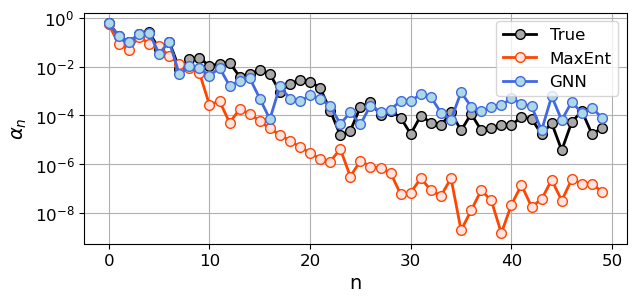

In [7]:
# N = int(np.random.rand() * 1e4)
# N = 9610

fig,ax = plt.subplots(ncols=1, figsize=(7,3))
ax.plot(abs(coeffs[N,:200:2]),
    marker='o',
    linestyle='-',
    color='black',               # line color
    markerfacecolor='darkgray',       # fill color
    markeredgecolor='black',     # circle border color
    markersize=7,
    linewidth=2,
    label=r'True'
)
ax.plot(abs(coeffs_maxent[N,:200:2]),
    marker='o',
    linestyle='-',
    color='orangered',               # line color
    markerfacecolor='mistyrose',       # fill color
    markeredgecolor='orangered',     # circle border color
    markersize=7,
    linewidth=2,
    label=r'MaxEnt'
)
# ax.plot(abs(coeffs_maxent2[N,:200:2]),
#     marker='o',
#     linestyle='-',
#     color='orange',               # line color
#     markerfacecolor='mistyrose',       # fill color
#     markeredgecolor='orangered',     # circle border color
#     markersize=7,
#     linewidth=2,
#     label=r'MaxEnt $\beta=10$'
# )
ax.plot(abs(coeffs_GNN[N,:200:2]),
    marker='o',
    linestyle='-',
    color='royalblue',               # line color
    markerfacecolor='lightblue',       # fill color
    markeredgecolor='royalblue',     # circle border color
    markersize=7,
    linewidth=2,
    label=r'GNN'
)
ax.set_yscale("log")
ax.legend(fontsize=12)
ax.set_xlabel("n", fontsize=14)
ax.set_ylabel(r'$\alpha_n$', fontsize=14)
ax.tick_params(axis='both', labelsize=12)  # Adjust 14 to your desired font size
ax.grid()
plt.savefig(f"examples/Acoeff_avnoise_ex{N}.pdf", format="pdf", bbox_inches="tight")


# ax[1].set_ylim([0,1e-3])

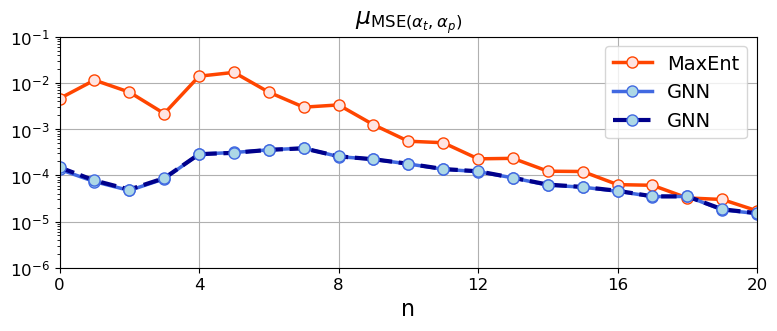

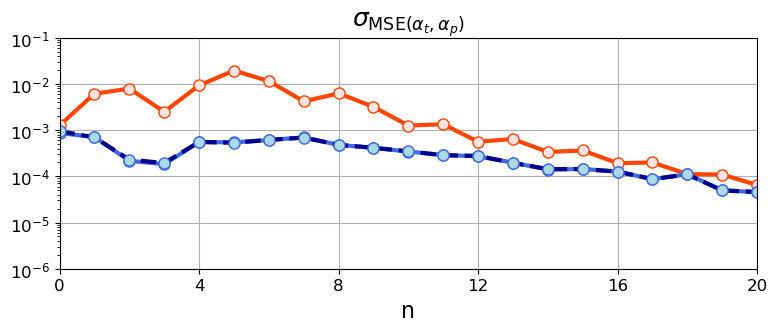

In [8]:
from matplotlib.ticker import MaxNLocator

n_w = A.shape[1]
coeff_std_maxent = np.zeros((n_w))
coeff_std_GNN = np.zeros((n_w))
coeff_std_GNN_valid = np.zeros((n_w))
coeff_mean_maxent = np.zeros((n_w))
coeff_mean_GNN = np.zeros((n_w))
coeff_mean_GNN_valid = np.zeros((n_w))

for nv in range(n_w):
    coeff_std_maxent[nv] = np.std((coeffs[:,nv] - coeffs_maxent[:,nv])**2)
    coeff_std_GNN[nv] = np.std((coeffs_all[:,nv] - coeffs_GNN[:,nv])**2)
    coeff_mean_maxent[nv] = np.mean((coeffs[:,nv] - coeffs_maxent[:,nv])**2)
    coeff_mean_GNN[nv] = np.mean((coeffs_all[:,nv] - coeffs_GNN[:,nv])**2)

for nv in range(n_w):
    coeff_mean_GNN_valid[nv] = np.mean((coeffs_all[validation_idx,nv] - coeffs_GNN[validation_idx,nv])**2)
    coeff_std_GNN_valid[nv] = np.std((coeffs_all[validation_idx,nv] - coeffs_GNN[validation_idx,nv])**2)


fig, ax = plt.subplots(ncols=1, figsize=(9,3))
ax.plot(coeff_mean_maxent[::2],
    marker='o',
    linestyle='-',
    color='orangered',               # line color
    markerfacecolor='mistyrose',       # fill color
    markeredgecolor='orangered',     # circle border color
    markersize=8,
    linewidth=2.5,
    label=r'MaxEnt'
)
ax.plot(coeff_mean_GNN[::2],
    marker='o',
    linestyle='-',
    color='royalblue',               # line color
    markerfacecolor='lightblue',       # fill color
    markeredgecolor='royalblue',     # circle border color
    markersize=8,
    linewidth=2.5,
    label=r'GNN'
)
ax.plot(coeff_mean_GNN_valid[::2],
    marker='o',
    linestyle='--',
    color='darkblue',               # line color
    markerfacecolor='lightblue',       # fill color
    markeredgecolor='royalblue',     # circle border color
    markersize=8,
    linewidth=3,
    label=r'GNN'
)

ax.set_xlabel(r'n', fontsize=16)
ax.set_title(r'$\mu_{\text{MSE}(\alpha_t,\alpha_p)}$', fontsize=17)
ax.set_ylim([1e-6,1e-1])
ax.set_xlim([0,20])
ax.legend(fontsize=14)
ax.grid()
ax.set_yscale("log")
ax.tick_params(axis='both', labelsize=12)  # Adjust 14 to your desired font size
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust 5 to desired number of ticks
# ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust 5 to desired number of ticks
plt.savefig(f"statistics/coeff_mse_beta{str(maxent_beta)}.pdf", format="pdf", bbox_inches="tight")

fig, ax = plt.subplots(ncols=1, figsize=(9,3))
ax.plot(coeff_std_maxent[::2],
    marker='o',
    linestyle='-',
    color='orangered',               # line color
    markerfacecolor='mistyrose',       # fill color
    markeredgecolor='orangered',     # circle border color
    markersize=8,
    linewidth=3,
    label=r'MaxEnt'
)
ax.plot(coeff_std_GNN[::2],
    marker='o',
    linestyle='-',
    color='royalblue',               # line color
    markerfacecolor='lightblue',       # fill color
    markeredgecolor='royalblue',     # circle border color
    markersize=8,
    linewidth=3,
    label=r'GNN full'
)
ax.plot(coeff_std_GNN_valid[::2],
    marker='o',
    linestyle='--',
    color='darkblue',               # line color
    markerfacecolor='lightblue',       # fill color
    markeredgecolor='royalblue',     # circle border color
    markersize=8,
    linewidth=3,
    label=r'GNN validation'
)
ax.set_xlabel(r'n', fontsize=16)
ax.set_title(r'$\sigma_{\text{MSE}(\alpha_t,\alpha_p)}$', fontsize=18)
ax.set_ylim([1e-6,1e-1])
ax.set_xlim([0,20])
ax.set_yscale("log")
ax.grid()

ax.tick_params(axis='both', labelsize=12)  # Adjust 14 to your desired font size
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust 5 to desired number of ticks
# ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust 5 to desired number of ticks
plt.savefig(f"statistics/coeff_std_beta{str(maxent_beta)}.pdf", format="pdf", bbox_inches="tight")

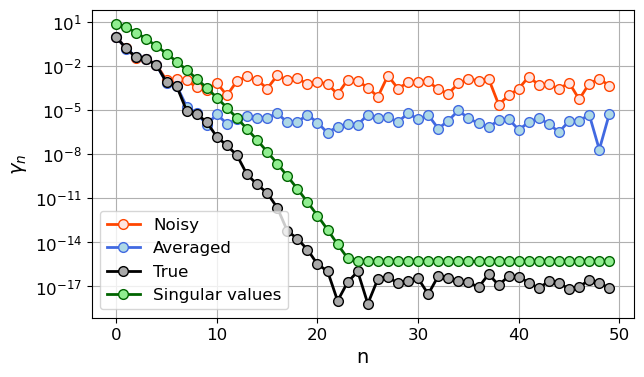

In [9]:
coeffs_gtau = np.zeros((gtau.shape[0], gtau.shape[1]))
gtau_sum = 0
coeffs_gtau_sum = 0

for n in range(gtau.shape[0]):
    coeffs_gtau[n,:] = gtau[n] @ u

gtau_clean = A[N]/np.trapz(A[N]) @ k.transpose()

noise_sample = 10000
gtau_noise100 = np.zeros((noise_sample, gtau.shape[1]))
for n in range(noise_sample):
    gtau_noise100[n] = gtau_clean + np.random.rand(gtau.shape[1])*1e-3
for nn in range(noise_sample):
    gtau_sum += gtau_noise100[nn]
gtau_sum /= noise_sample

coeffs_gtau_sum = gtau_sum @ u
coeffs_gtau_clean = gtau_clean @ u



fig,ax = plt.subplots(ncols=1, figsize=(7,4))
ax.plot(abs(coeffs_gtau)[N,::2],
    marker='o',
    linestyle='-',
    color='orangered',               # line color
    markerfacecolor='mistyrose',       # fill color
    markeredgecolor='orangered',     # circle border color
    markersize=7,
    linewidth=2,
    label=r'Noisy'
)
ax.plot(abs(coeffs_gtau_sum)[::2],
    marker='o',
    linestyle='-',
    color='royalblue',               # line color
    markerfacecolor='lightblue',       # fill color
    markeredgecolor='royalblue',     # circle border color
    markersize=7,
    linewidth=2,
    label=r'Averaged'
)
ax.plot(abs(coeffs_gtau_clean)[::2],
    marker='o',
    linestyle='-',
    color='black',               # line color
    markerfacecolor='darkgray',       # fill color
    markeredgecolor='black',     # circle border color
    markersize=7,
    linewidth=2,
    label=r'True'
)
ax.plot(s[::2],
    marker='o',
    linestyle='-',
    color='darkgreen',               # line color
    markerfacecolor='lightgreen',       # fill color
    markeredgecolor='darkgreen',     # circle border color
    markersize=7,
    linewidth=2,
    label="Singular values"
)

ax.set_yscale("log")
ax.legend(fontsize=12)
ax.set_xlabel("n", fontsize=14)
ax.set_ylabel(r'$\gamma_n$', fontsize=14)
ax.grid()
ax.tick_params(axis='both', labelsize=12)  # Adjust 14 to your desired font size
plt.savefig(f"Gcoeff_avnoise_ex{N}.pdf", format="pdf", bbox_inches="tight")


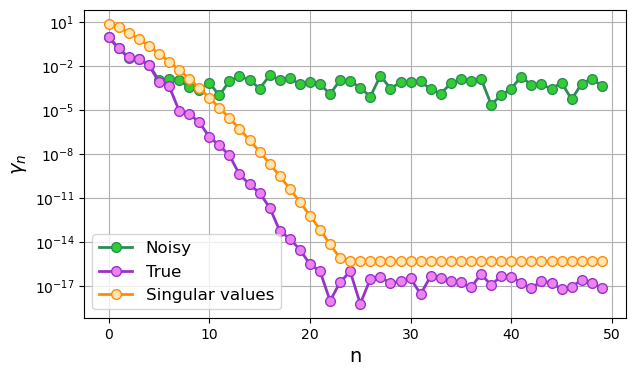

In [10]:
gtau_clean = A[N]/np.trapz(A[N]) @ k.transpose()
coeffs_gtau_clean = gtau_clean @ u


fig,ax = plt.subplots(ncols=1, figsize=(7,4))
ax.plot(abs(coeffs_gtau)[N,::2],
    marker='o',
    linestyle='-',
    color='seagreen',               # line color
    markerfacecolor='limegreen',       # fill color
    markeredgecolor='seagreen',     # circle border color
    markersize=7,
    linewidth=2,
    label=r'Noisy'
)

ax.plot(abs(coeffs_gtau_clean)[::2],
    marker='o',
    linestyle='-',
    color='darkorchid',               # line color
    markerfacecolor='violet',       # fill color
    markeredgecolor='darkorchid',     # circle border color
    markersize=7,
    linewidth=2,
    label=r'True'
)
ax.plot(s[::2],
    marker='o',
    linestyle='-',
    color='darkorange',               # line color
    markerfacecolor='moccasin',       # fill color
    markeredgecolor='darkorange',     # circle border color
    markersize=7,
    linewidth=2,
    label="Singular values"
)
ax.set_yscale("log")
ax.legend(fontsize=12)
ax.set_xlabel("n", fontsize=14)
ax.set_ylabel(r'$\gamma_n$', fontsize=14)
ax.grid()
# plt.savefig("Gcoeff_avnoise_ex.pdf", format="pdf", bbox_inches="tight")


# ax[1].plot(gtau[N])
# ax[1].plot(gtau_sum)
# ax[1].plot(gtau_clean)


In [ ]:
MaxEnt_data = {}
beta = [10,20,30,40]
for b in beta:
    MaxEnt_data[str(b)] = {}
    with h5py.File(WORKDIR+f"/valid_scripts/gtau_beta{b}_w2dyn/beta{b}/maxent_ctqmc_data_100_b{b}.h5", "r") as f:
        MaxEnt_data[str(b)]["gtau"] = f["gtau"][:]
        MaxEnt_data[str(b)]["A"] = f["A"][:]
        MaxEnt_data[str(b)]["w"] = f["w"][:]
        MaxEnt_data[str(b)]["A_maxent"] = f["A_maxent"][:]
        MaxEnt_data[str(b)]["w_maxent"] = f["w_maxent"][:]
        MaxEnt_data[str(b)]["maxent_beta"] = np.array(f["beta"])
        MaxEnt_data[str(b)]["U_maxent"] =  np.array(f["U"])

print(MaxEnt_data[str(b)]["A_maxent"].shape)


(6, 100)


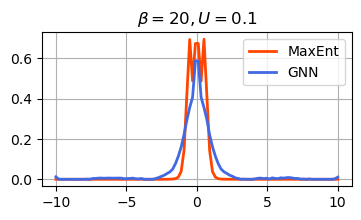

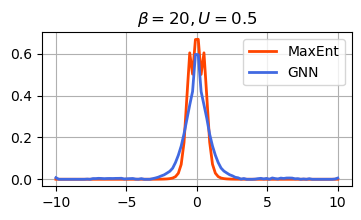

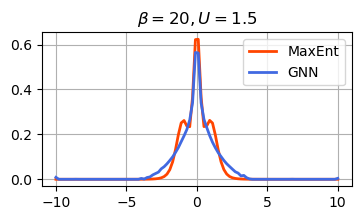

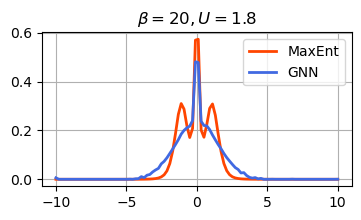

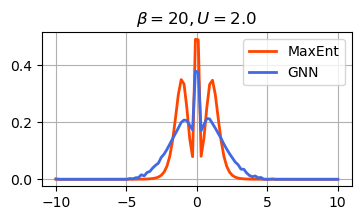

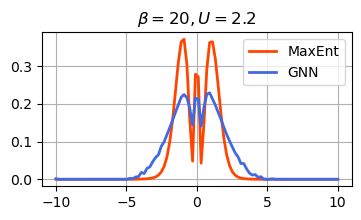

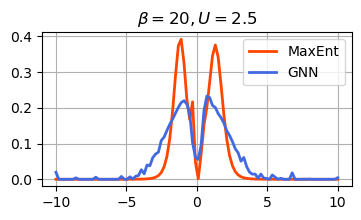

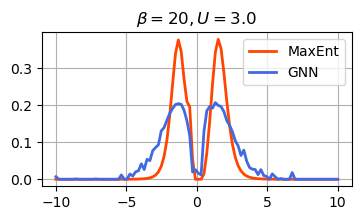

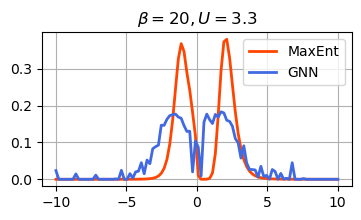

In [13]:
b = 20
BETA = b
b = str(b)
w_max=200/BETA
Nt = 1000
tau = np.linspace(0.0, BETA, Nt)
w = np.linspace(-w_max, w_max, num=100, endpoint=True)
# w2 = np.linspace(-10., 10., num=100, endpoint=True)
U_sorted = np.sort(MaxEnt_data[str(b)]["U_maxent"])
for u in U_sorted:
    # print(u, np.where(GNN_ctqmc[b]["U_ctqmc_GNN"] == u)[0])
    idx_maxent = np.where(MaxEnt_data[str(b)]["U_maxent"] == u)[0]
    idx_GNN = np.where(GNN_ctqmc[b]["U_ctqmc_GNN"] == u*10)[0]
    GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN, GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN][0]<0] = 0
    GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN] = GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN] / np.trapz(x=w, y=GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN])
    MaxEnt_data[str(b)]["A_maxent"][idx_maxent] = MaxEnt_data[str(b)]["A_maxent"][idx_maxent] / np.trapz(x=w, y=MaxEnt_data[str(b)]["A_maxent"][idx_maxent])
    fig, ax = plt.subplots(ncols=1, figsize=(4,2))
    ax.plot(w,MaxEnt_data[str(b)]["A_maxent"][idx_maxent][0], linewidth=2, color="orangered", label="MaxEnt")
    ax.plot(w,GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN][0], linewidth=2, color="royalblue", label="GNN")
    # ax.set_xlim([-7,7])
    ax.set_title(r'$\beta=$'+b+'$, U=$'+str(u))
    ax.legend()
    ax.grid()
    plt.savefig(f"ctqmc_spectra/A_U{str(int(round(u,2)*100))}_b{b}.pdf", format="pdf", bbox_inches="tight")

# ax[1].plot(Green_ctqmc[N], linewidth=2.5, color="orangered")


In [ ]:
import numpy as np
import os

PATH = WORKDIR+"/valid_scripts/gtau_beta20_w2dyn/"

U_sorted = np.sort(MaxEnt_data[str(b)]["U_maxent"])
A0_GNN = []
A0_maxent = []
for u in U_sorted:
    idx_GNN = np.where(GNN_ctqmc[b]["U_ctqmc_GNN"] == u*10)[0][0]
    idx_maxent = np.where(MaxEnt_data[str(b)]["U_maxent"] == u)[0][0]
    GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN] = GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN] / np.trapz(x=w, y=GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN])
    MaxEnt_data[str(b)]["A_maxent"][idx_maxent] = MaxEnt_data[str(b)]["A_maxent"][idx_maxent] / np.trapz(x=w, y=MaxEnt_data[str(b)]["A_maxent"][idx_maxent])
    A0_GNN.append(GNN_ctqmc[b]["A_ctqmc_GNN"][idx_GNN][50])
    A0_maxent.append(MaxEnt_data[str(b)]["A_maxent"][idx_maxent][50])

A0_GNN = np.array(A0_GNN)
A0_maxent = np.array(A0_maxent)
print(A0_GNN.shape)

(9,)


In [15]:

PATH = WORKDIR+f"/valid_scripts/gtau_beta{str(b)}_w2dyn/data/"
gtau_ctqmc = []
occ_ctqmc = []
nono = []
_ = np.load(PATH+"data.npz", allow_pickle=True)
data = {key: _[key].item() for key in _}
for u in U_sorted:
    gtau_ctqmc.append(data[str(int(u*100))]["gtau"][0,0,:])
    occ_ctqmc.append(data[str(int(u*100))]["occ"][0,0,0,1])

gtau_ctqmc = np.array(gtau_ctqmc)
occ_ctqmc = np.array(occ_ctqmc)
print(U_sorted.shape, gtau_ctqmc.shape)

(9,) (9, 1000)


/tmp/ipykernel_4077421/688488126.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


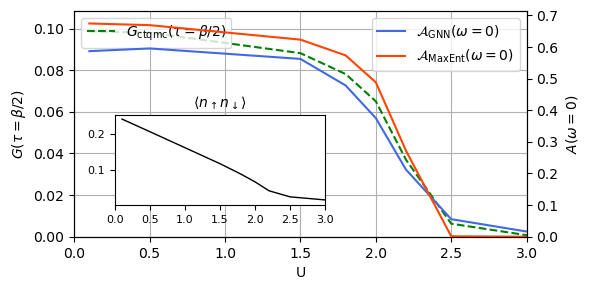

In [16]:
fig, ax1 = plt.subplots(figsize=(6,3))

# left y-axis
# ax1.plot(occ[:,0], occ[:,1], color="darkorchid", label="occ")
ax1.plot(U_sorted, gtau_ctqmc[:,500], "--", color="green", label=r'$G_\text{ctqmc}(\tau=\beta/2)$')
ax1.set_xlabel("U")   # replace if you want
ax1.set_ylabel(r"$G(\tau=\beta/2)$")
ax1.set_ylim([0,1.1*np.max(gtau_ctqmc[:,500])])
ax1.set_xlim([0,30/10])
ax1.legend(loc="upper left")
ax1.grid()

# right y-axis
ax2 = ax1.twinx()
# ax2.plot(occ[:,0], siv_ctqmc[:], color="green", label="siv_ctqmc", linestyle="-")
ax2.plot(U_sorted, A0_GNN, color="royalblue", label=r'$\mathcal{A}_\text{GNN}(\omega=0)$')
ax2.plot(U_sorted, A0_maxent, color="orangered", label=r'$\mathcal{A}_\text{MaxEnt}(\omega=0)$')
ax2.set_ylabel(r"$A(\omega=0)$")
ax2.set_ylim([0,1.2*np.max(A0_GNN)])
ax2.set_xlim([0,30/10])
ax2.legend(loc="upper right")

# one combined legend
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

# inset plot: [left, bottom, width, height] in figure coordinates (0..1)
ax_in = fig.add_axes([0.2, 0.3, 0.35, 0.3])
ax_in.plot(U_sorted, occ_ctqmc[:], linewidth=1, color="black", label="occ")
ax_in.set_title(r'$\langle n_\uparrow n_\downarrow \rangle$', fontsize=10)
ax_in.set_xlim([0,30/10])
ax_in.tick_params(axis='x', labelsize=8)
ax_in.tick_params(axis='y', labelsize=8)
fig.tight_layout()

fig.savefig("ctqmc_spectra/A0Gb2occ.pdf", format="pdf", bbox_inches="tight")
plt.show()

# fig.savefig(f"ctqmc_spectra/A0Gb2occ.pdf", format="pdf", bbox_inches="tight")
